In [1]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals
import pints
import pints.toy as toy
import numpy as np
import logging
import math
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

In [14]:
class SGD(pints.PopulationBasedOptimiser):
    """
    Finds the best parameters using the SGD method. 
    SGD stands for Stochastic Gradient Descent.
    """

    def __init__(self, x0, sigma0=None, boundaries=None, 
                     use_exact_grad=False):
        super(SGD, self).__init__(x0, sigma0, boundaries)

        # Set initial state
        self._running = False
        self._ready_for_tell = False

        # Best solution found
        self._xbest = pints.vector(x0)
        self._fbest = float('inf')

        # Python logger
        self._logger = logging.getLogger(__name__)
        self._population_size = 20
        
        # Do we use the approximate gradients?
        self._use_exact_grad = use_exact_grad

    def ask(self):
        """ See :meth:`Optimiser.ask()`. """
        # Initialise on first call
        if not self._running:
            self._initialise()

        # Ready for tell now
        self._ready_for_tell = True
      
        # New sample with all but one parameter fixed
        # Issue, our fbest and xbest are meaning less because we are not exploring on all 
        # params at the same time.. (isn't a huge issue however)
        self._xs = np.array([]).reshape(0,self._n_parameters)
        self._zs = np.array([np.random.normal(1, 0.005) 
                             for i in range(self._population_size)])
        for i in range(self._n_parameters):
            # Modify only for one parameter
            temp = np.full((self._population_size, self._n_parameters), self._weights)
            temp[:,i] *= self._zs
            self._xs = np.vstack([self._xs, temp])
            
        
        if self._manual_boundaries:
            # Manual boundaries? Then pass only xs that are within bounds
            self._user_ids = np.nonzero(
                [self._boundaries.check(x) for x in self._xs])
            self._user_xs = self._xs[self._user_ids]
            if len(self._user_xs) == 0:     # pragma: no cover
                self._logger.warning(
                    'All points requested by SGD are outside the boundaries.')
        else:
            self._user_xs = self._xs

        # Set as read-only and return
        self._user_xs.setflags(write=False)
        return self._user_xs

    def fbest(self):
        """ See :meth:`Optimiser.fbest()`. """
        return self._fbest

    def _initialise(self):
        """
        Initialises the optimiser for the first iteration.
        """
        assert(not self._running)
        
        #TODO, make change possible
        self._step_size = 0.00000000001
        
        self._manual_boundaries = False
        self._boundary_transform = None
        if isinstance(self._boundaries, pints.RectangularBoundaries):
            self._boundary_transform = pints.TriangleWaveTransform(
                self._boundaries)
        elif self._boundaries is not None:
            self._manual_boundaries = True

        self._weights = np.array(self._x0)
        
        # Update optimiser state
        self._running = True

    def name(self):
        """ See :meth:`Optimiser.name()`. """
        return 'Constant Step Stochastic Gradient Descent (SGD)'

    def running(self):
        """ See :meth:`Optimiser.running()`. """
        return self._running

    def set_step_size(self, step, scalar=True):
        self._step_size = step
        
    def gradient(self):
        return self._gradient

    def _suggested_population_size(self):
        """ See :meth:`Optimiser._suggested_population_size(). """
        return 4 + int(3 * np.log(self._n_parameters))

    def tell(self, fx):
        """ See :meth:`Optimiser.tell()`. """
        if not self._ready_for_tell:
            raise Exception('ask() not called before tell()')
        self._ready_for_tell = False

        
        if self._manual_boundaries and len(fx) < self._population_size:
            user_fx = fx
            fx = np.ones((self._population_size, )) * float('inf')
            fx[self._user_ids] = user_fx
        
        
        if self._use_exact_grad:
            grads = [f[1] for f in fx]
            fx = [f[0] for f in fx]
            self._gradient = self._exact_grad(grads)
        else: 
            self._gradient = self._approx_grad(fx)
        order = np.argsort(fx)
                    
        self._weights -= self._step_size * self._gradient
                
        if fx[order[0]] < self._fbest:
            self._fbest = fx[order[0]]
            self._xbest = self._xs[order[0]]

    # This should approximate the gradient. 
    # We are essentially approximating the partial derivative for each param
    def _approx_grad(self, scores):
        n = self._n_parameters
        p = self._population_size
        result = np.zeros(n)
        for i in range(n):
            for j in range(p):
                for k in range(p):
                    if j == k:
                        continue
                    result[i] += (scores[j + i*p] - scores[k + i*p]) / (self._user_xs[j + i*p][i] - self._user_xs[k + i*p][i])
        return result / (p * (p-1))

    # This function takes the gradients on each timestep t as input (so we are not computing the individual gradients here)
    # We are using the individual gradients and take the average to get an estimation of the real gradients for each 
    # time step t
    def _exact_grad(self, grads):
        n = self._n_parameters
        p = self._population_size
        result = np.zeros(n)
        for j in range(p):
                    result += grads[j]
        return result / p

    def xbest(self):
        """ See :meth:`Optimiser.xbest()`. """
        return self._xbest 
    
    def weights(self):
        return self._weights     

In [15]:
model_dict=dict()

In [16]:
# HH_IK #
HH_dict = dict()

HH_dict['name'] = "Hodgkin Huxley IK model"
HH_dict['model'] = toy.HodgkinHuxleyIKModel()

HH_dict['real_parameters'] = HH_dict['model'].suggested_parameters() # 0.01, 10, 10, 0.125, 80
HH_dict['times'] = HH_dict['model'].suggested_times()

HH_dict['boudaries'] = pints.RectangularBoundaries([-2, -200, -200, -2, -200], [2, 200, 200, 2, 200])

HH_dict['x0'] = 0.001, 5, 20, 0.335, 37

model_dict['Hodgkin_Huxley'] = HH_dict

Currently testing on Hodgkin_Huxley
Starting SGD
Failed 0 times
Average best score for SGD after 1 trials 723.95999997256


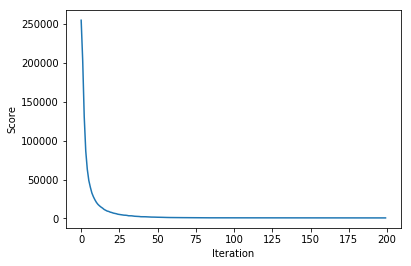

All scores


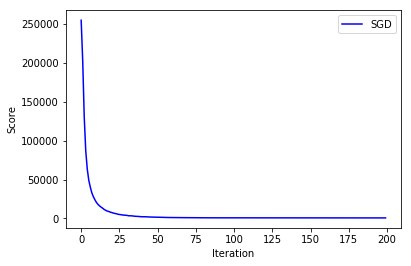

Done with Hodgkin_Huxley
############################################


In [17]:
for key, value in model_dict.items():
    
    print("Currently testing on", key)
    
    x0 = value['x0']
    
    sgd = SGD(x0)

    # ("SGD", sgd)
    opts = [ ("SGD", sgd, "b") ]

    model_testbed(value['model'], value['real_parameters'], value['times'], opts)
    
    print("Done with", key)
    print('############################################')

In [8]:
def model_testbed(model,
                  real_parameters,
                  times,
                  optimizers_info,
                  iterations=200,
                  tries=1):
    
    #Generate the values
    try:
        values, _ = model.simulateS1(real_parameters, times)
    except:
        values = model.simulate(real_parameters, times)
        
    # Add noise
    values += np.random.normal(0, 10, values.shape)
    # Create an object with links to the model and time series
    try:
        my_problem = pints.SingleOutputProblem(model, times, values)
    except:
        my_problem = pints.MultiOutputProblem(model, times, values)
    
    # Select a score function
    score = pints.MeanSquaredError(my_problem)
    
    all_results_info = list()
    
    for name, opt, color in optimizers_info:
        print("Starting", name)
        avg_best_fxs = []
        avg_best_xs = []
        fail_count = 0
        for j in range(tries):    
            best_fxs = []
            best_xs = []
            #try:
            for i in range(iterations):
                xs = opt.ask()
                # Save the values for the plot 
                if (i) % 5 == 0:
                    best_xs.append(opt.xbest())
                # Evaluate the scores
                fxs = [score(x) for x in xs]
                opt.tell(fxs)
                # Store the best score
                best_fxs.append(opt.fbest())
            avg_best_fxs.append(best_fxs)
            #except Exception as e:
             #   print('One run failed: ', e)
             #   print()
             #   fail_count += 1
        avg_best_fxs = np.average(avg_best_fxs, 0)
        all_results_info.append((avg_best_fxs, color, name))
        
        # Show how the score converges
        print("Failed", fail_count, "times")
        if fail_count == tries:
            return
        print("Average best score for", name, "after", tries , "trials", avg_best_fxs[-1])
        axes = plt.gca()
        plt.xlabel('Iteration')
        plt.ylabel('Score')
        plt.plot(avg_best_fxs)
        plt.show()
    
    # Show how the score converges
    print("All scores")
    axes = plt.gca()
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    for avg, color, name in all_results_info:
        plt.plot(avg, color, label=name)
    plt.legend(loc='upper right')
    plt.show()
            

In [6]:
def visualize_SGD(step_size): 
    
    def SGD_approx_grad():
        # Create an SGD object
        sgd = SGD(x0)
        # Run optimisation
        best_fxs = []
        x = [[],[]]
        for i in range(500):
            # Get the next points to evaluate
            xs = sgd.ask()
            sgd.set_step_size(step_size)
            if (i+1) % 1 == 0:
                x[0].append(sgd.weights()[0])
                x[1].append(sgd.weights()[1])
            # Evaluate the scores
            fxs = [score(x) for x in xs]
            # Pass the result back to SGD
            sgd.tell(fxs)


            # Store the best score
            best_fxs.append(sgd.fbest())
        return best_fxs, sgd.fbest(), sgd.xbest(), sgd.weights(), x

    best_fxs, fbest, xbest, weights, x= SGD_approx_grad()
    #print(xbest)
    print(weights)
    # Show how the score converges
    axes = plt.gca()
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    axes.set_ylim([-5,5000])
    plt.plot(best_fxs)
    plt.show()


    fig, ax = plt.subplots()
    plt.xlabel("x0")
    plt.ylabel('x1')
    plt.plot(x[0],x[1])
    plt.plot(x[0][0], x[1][0], 'go')
    plt.plot(x[0][-1], x[1][-1], 'ro')
    plt.plot(*real_parameters, 'bD')

    x0s = np.linspace(0., 1., 100)
    x1s = np.linspace(400.0, 600.0, 100)
    X0, X1 = np.meshgrid(x0s,x1s)
    Y = np.array([ [score([X0[i][j], X1[i][j]]) for j in range(len(X0[0]))] for i in range(len(X0)) ])
    cm = plt.cm.get_cmap('viridis')
    levels = [200.0, 1000.0, 2000.0, 4000.0, 8000.0, 12000.0, 14000.0]
    cp = plt.contour(X0, X1, Y, levels)

    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)
    ax.set_xlim([0,1])
    ax.set_ylim([400,600])
    plt.show()


In [ ]:
step_sizes = [0.00005,0.000001,0.000175]
for step_size in step_sizes:
    visualize_SGD(step_size)

In [ ]:
def SGD_real_grad():
    # Create an SGD object
    sgd = SGD(x0, use_exact_grad=True)
    # Run optimisation
    best_fxs = []
    for i in range(100):
        # Get the next points to evaluate
        xs = sgd.ask()
        # Evaluate the scores
        grads = [score.evaluateS1(x) for x in xs]        
        # Pass the result back to SGD
        sgd.tell(grads)
        # Store the best score
        best_fxs.append(sgd.fbest())

    return best_fxs, sgd.fbest(), sgd.xbest(), sgd.weights()
    
best_fxs, fbest, xbest, weights = SGD_real_grad()
#print(xbest)
print(weights)
# Show how the score converges
axes = plt.gca()
plt.xlabel('Iteration')
plt.ylabel('Score')
axes.set_ylim([-5,5000])
plt.plot(best_fxs)
plt.show()

In [ ]:
win_count = []
f_diff = []
for i in range(100):
    _, approx_f, _, _ = SGD_approx_grad()
    _, exact_f, _, _ = SGD_real_grad()
    f_diff.append(approx_f - exact_f)
    win_count.append(1 if approx_f > exact_f else -1)

count_sum = sum(win_count)
diff_sum = sum(f_diff)
print("APPROX WINS" if count_sum < 0 else "REAL WINS", "on counts")
print("APPROX WINS" if diff_sum < 0 else "REAL WINS", "on diff")
print(count_sum)
print(diff_sum)